<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Translated by Gleb Filatov (@gleb_filatov). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center> Project "Alice". User Identification Based on Visited Websites
## <center> Week 3. Visual data analysis, and feature engineering
    
This week, we will start doing data exploration via plots as well as some feature engineering. We'll build and explore some features for you so you can build up on this and be able to make features on your own. 

**Week 3 roadmap**
- Part 1. Feature engineering
- Part 2. Visual data exploration
- Part 3. Further feature engineering
- Part 4. Validation of prepared features

In this task we will extensively utilize **seaborn** library (you can install it by using *pip install seaborn* command). Also it will be helpful to take a look at [matplotlib](http://matplotlib.org/users/) and [seaborn](http://seaborn.pydata.org/) docs.

**Your task**
1. Fill in the missing code in the provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/19AKGoSekzO-exZhFWsCHSb3-wR-KT_ATtREKdPWKd24)

## Part 1. Feature engineering

In [66]:
# disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
# pip install seaborn
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
%matplotlib inline

In [2]:
# change the path to data if necessary
PATH_TO_DATA = '../../data/capstone_user_identification'

Create a new function *prepare_train_set_with_fe*, based on *prepare_train_set* and *prepare_sparse_train_set_window*, which will produce following features:

- session_timespan - session duration in seconds (difference between maximal and minimal website visit time in one session)
- #unique_sites - number of unique sites in session
- start_hour - hour, when session started (hour of the minimal timestamp of this session)
- day_of_week - day of week (day of the minimal timestamp of this session)

Function should return a new DataFrame (just like function *prepare_train_set* did) but with **4 more features**. The <font color = 'red'>order</font>, in which features are added is the following - **site1, ..., site10, session_timespan, #unique_sites, start_hour, day_of_week, user_id.**

In [49]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    user_files = glob('/'.join([path_to_csv_files, '*.csv']))
    df = []
    freq = {}
    id_counter = 1
    site_dict = pd.read_pickle(site_freq_path)
    for user_file in user_files:
        with open(user_file, 'r') as file:
            user_id = int(user_file[-8:-4])
            file.readline()
            lines = []
            dates = []
            for line in file:
                lines.append(line.split(',')[1].replace('\n', ''))
                dates.append(pd.to_datetime(line.split(',')[0]))
                if len(lines) >= session_length:
                    session = process(lines, dates, site_dict, session_length)
                    session.append(user_id)
                    df.append(session)
                    lines = lines[window_size:]
                    dates = dates[window_size:]
            while len(lines) > 0:
                session = process(lines, dates, site_dict, session_length)
                session.append(user_id)
                df.append(session)
                for i in range(min([len(lines), window_size])):
                    lines.pop(0)
                    dates.pop(0)
    # column_names = ['site{}'.format(i) for i in range(1, session_length+1)]
    # column_names.append('user_id')
    # df = pd.DataFrame(df, columns = column_names)
    # X = df.iloc[:, :-1].values
    # y = df.iloc[:, -1].values
    # X = csr_generator(X)
    # return(X, y)
    df = pd.DataFrame(df, columns = feature_names)
    return(df)
def process(lines, dates, site_dict, session_length):
    session = []
    for line in lines:
        session.append(site_dict[line][0])
    if len(session) < session_length:
        for i in range(session_length - len(session)):
            session.append(0)
    time_diff = np.diff(dates)
    time_diff = [x.total_seconds() for x in time_diff] + np.zeros(session_length-len(time_diff)-1).tolist()
    session = session + time_diff
    session.append((dates[-1] - dates[0]).total_seconds())
    session.append(len(np.unique(lines)))
    session.append(dates[0].hour)
    session.append(dates[0].dayofweek)
    return(session)
def csr_generator(X):
    indptr = [0]
    indices = []
    data = []
    for d in X:
        for term in d:
            index = term
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr_out = csr_matrix((data, indices, indptr), dtype=int)[:,1:]
    return(csr_out)

Let's test the function on a toy example.

In [50]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [51]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,8,2,1,10,5,7,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


Now apply function *prepare_train_set_with_fe* to 10 users and specify session_length=10

In [76]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 9.92 s


In [77]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31


Apply function *prepare_train_set_with_fe* to 150 users and specify session_length=10

In [54]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 49s


In [78]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1290,321,1.0,1.0,1.0,4.0,0.0,1.0,0.0,49.0,0.0,57.0,5,8,4,6
1,2,23,1505,1290,321,321,113,73,49,49,0.0,0.0,26.0,1.0,10.0,73.0,0.0,1504.0,4.0,1618.0,8,8,4,6
2,321,205,1,1,1,1,73,321,2,1,1.0,10.0,1.0,5.0,16.0,56.0,1917.0,0.0,4.0,2010.0,5,8,4,6
3,1,1,6998,6998,5491,6998,6998,1,35,1,1.0,0.0,1.0,0.0,118.0,420.0,1460.0,6.0,0.0,2006.0,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,4.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,5,9,4,6


Save features **session_timespan, #unique_sites, start_hour and day_of_week for 10 and 150 users to pickle files.**

In [56]:
new_features_10users = train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [57]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'> Question 1. </font> What's the median session timespan for 10 users data?**

In [58]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'> Question 2. </font> What's the median day of week for 10 users data?**

In [59]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'> Question 3. </font> What's the median session start hour for 150 users data?**

In [60]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'> Question 4. </font> What's the median number of unique sites for 150 users data?**

In [61]:
train_data_150users['#unique_sites'].median()

7.0

## Part 2. Visual data exploration

Let's assign a name and a color to each user.

In [79]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [64]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

- Plot a histogram of session length (measured in seconds). Limit x axis to 200 (the right tail is very heavy). Make the histogram of color darkviolet and name the axes.

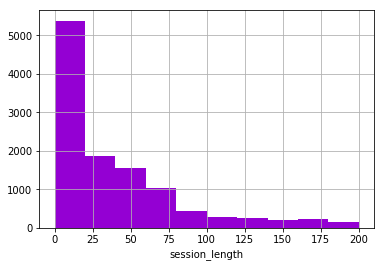

In [68]:
# you code here
train_data_10users['session_timespan'].hist(range=(0, 200), color='darkviolet')
plt.xlabel('session_length');

- Plot a histogram of number of unique sites in session. Make it of color aqua, name the axes.

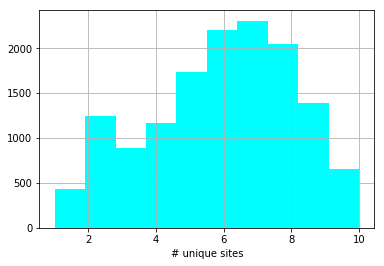

In [69]:
# you code here
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('# unique sites');

- Plot a histogram of number of unique sites for **each user separately**. Use *subplots* to fit all the 10 little pictures on a big one. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a color from *color_dic*. Sign the axes in each of the histograms.

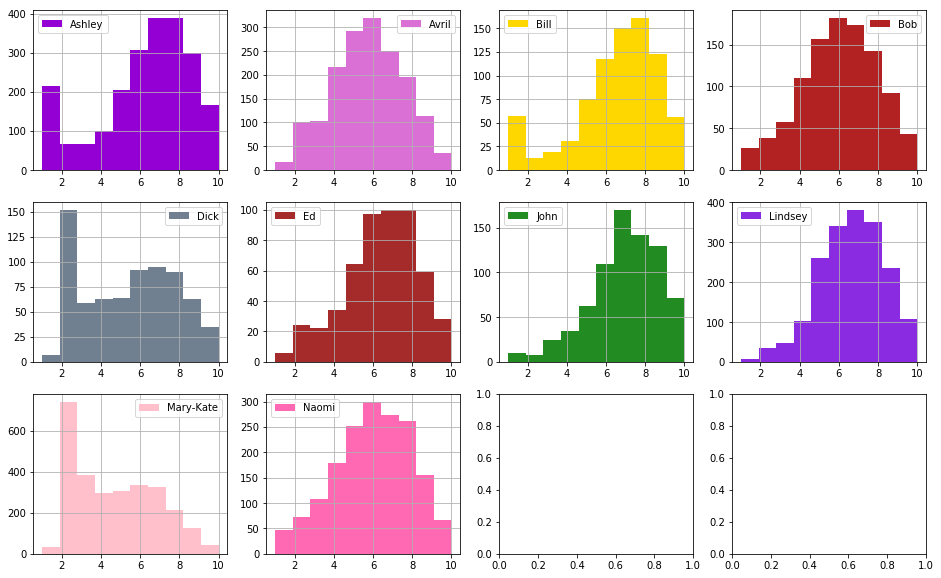

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['#unique_sites'].hist(color=color_dic[user], ax=axes.reshape(-1)[idx])
    axes.reshape(-1)[idx].legend([user])

- Plot a histogram of session start hour. Make histogram of color darkgreen, sign the axes.

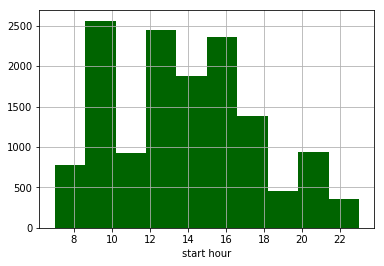

In [92]:
# you code here
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('start hour');

- Plot histograms of start hour distribution for each of 10 users separately. Use *subplots* to fit all the 10 little pictures on a big one. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a color from color_dic. Sign the axes in each of the histograms.

In [97]:
%config IPCompleter.greedy=True

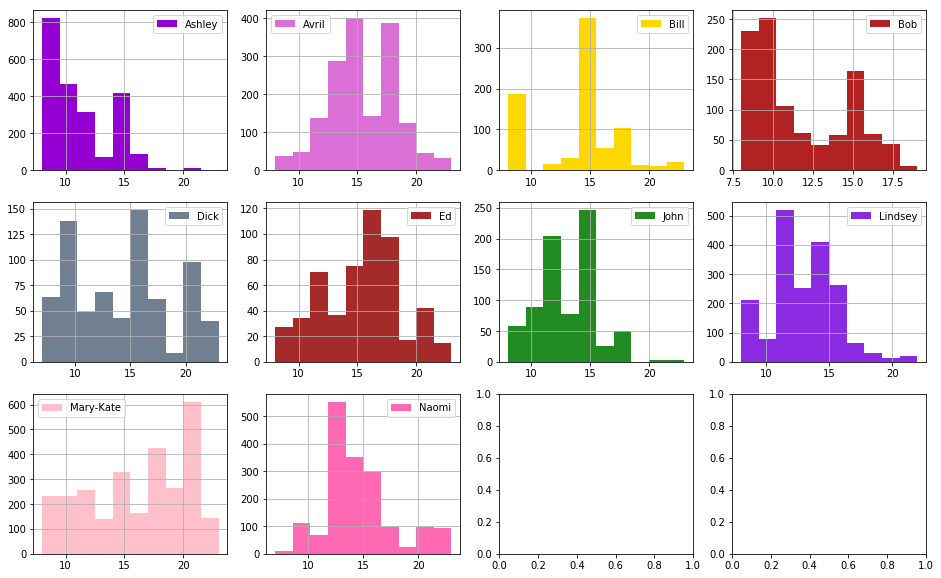

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    sub_df['start_hour'].hist(color=color_dic[user], ax=axes.reshape(-1)[idx])
    axes.reshape(-1)[idx].legend([user])

- Plot histogram of day of week distribution. Make it of color sienna, sign the axes. 

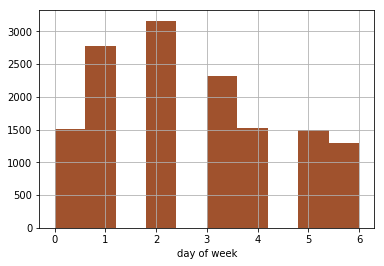

In [94]:
# you code here
train_data_10users['day_of_week'].hist(color='sienna')
plt.xlabel('day of week')

- Plot histograms of day of week distribution for each of 10 users separately. Use *subplots* to fit all the 10 little pictures on a big one. Change x axis labels to `['Mon','Tue','Wed','Thu','Fri','Sat','Sun']` using **set_xticklabels** method. Assign legend to each plot, it should have user's name on it. For each user color the corresponding histogram with a **color** from **color_dic**. Sign the axes in each of the histograms.

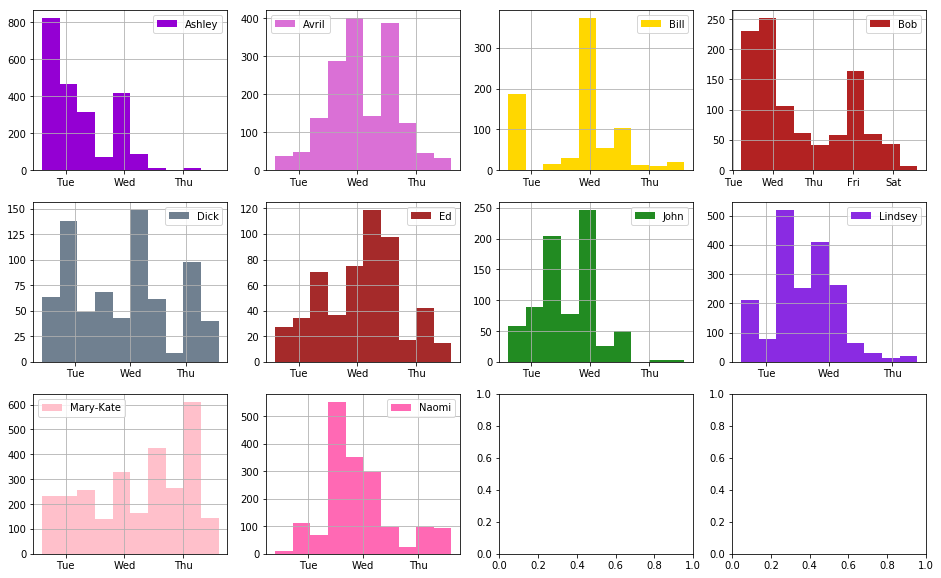

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#just a suggestion
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    sub_df['start_hour'].hist(color=color_dic[user], ax=axes.reshape(-1)[idx])
    axes.reshape(-1)[idx].legend([user])
    axes.reshape(-1)[idx].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

- Make conclusions about each user using the plots you just plotted. 

Load the pickle file frequency dict for 10 users you saved earlier.

In [ ]:
# # you code here
# with open 

- Find top-10 most visited sites (top10_sites) and corresponding number of visits (top10_freqs).

In [ ]:
# # you code here
# top10_freqs = 
# top10_sites = 

- Plot seaborn barplot that shows frequencies of top-10 sites visits. Make x-axis names (xticks) vertically oriented, otherwise they do not look good. 

In [ ]:
# # you code here
# sns.barplot 

## Part 3. Further feature engineering

This task will test your creativity. You have to come up with ideas, how else you can use website visit time and other features.

On the next week we will use a "bag of sites" to classify sessions based on which user they belong to. Additionaly, you will use features you create here and we'll see, whether model improves. It is wise to calculate them now and save, like we did in this assignment. 

You may go wild here and explore any feature you want - you have no constraints. 

- year, month and day of session start
- hour of sessions start (with respect to year, month and day)
- time of day
- average time spent on website (for top-30, for example)
- indicator function for popular site visit (again, top-30)
- facebook visit frequency
- .......

Implement the function to create new features and apply to initial data - catalogues with 10 and 150 users. Do it only for dataset, which was created with paramaters session_length=10 and window_size=10. Serialize resulting matrices via pickle. Function may return both only new features and old ones concatenated with new. You are free to choose function signature - no constraints here.

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    pass
    # you code here

In [ ]:
# # you code here
# new_features_10users = feature_engineering

In [ ]:
# # you code here
# new_features_150users = feature_engineering

10. Plot pictures for new features, explore them and comment on the results.

In [7]:
# you code here

Finally, save only those features to pickle files which, on your opinion, would help to identify user more precisely. This applies both to features, that we created in the beginning (session_timespan, #unique_sites, start_hour, day_of_week) and your own. You are free to create all these features not only for sessions of length 10, but for any other combination of *session_length* and *window_size*

In [ ]:
# # you code here
# selected_features_10users = 
# selected_features_150users = 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

Next week, we'll finally start training classification models.